# Figure Notebook

All figures and results included in Irvine et al. (2020) can be produced by running this notebook, with the exception of figures 5 and 6. There have been issues with transitioning the code for figure 5 that have not been resolved and figure 6 was produced offline in adobe illustrator.

In [1]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import my_shell_tools


# analysis
from scipy.stats import ttest_ind_from_stats
import itertools

# geomip_data
import os.path
# import cf
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
"""
Import all from projects python scripts
"""

#from get_glens_data import *
from get_NorESM_data import *
from analysis import *
from plotting import *


In [3]:

noresm_dir = '../NorESM_data/'
noresm_template = '{var}_Amon_NorESM1-ME_{exp}_{run}_2020-2100.nc' # The variables in curly brackets, e.g. {var} will be specified later

fileloc = noresm_dir + noresm_template.format(exp='rcp85',run='r1i1p1',var='tas') # FORMAT fills in the curly bracketed values so we now have a full file location.
# the above is the same as: fileloc = '../NorESM_data/tas_Amon_NorESM1-ME_rcp85_r1i1p1_2020-2100.nc' 

test_nc = Dataset(fileloc) # DATASET opens the netcdf file (.nc)


lons_nor = test_nc.variables['lon'][:]
lats_nor = test_nc.variables['lat'][:]
"""
At the end of this code box you'll see "test_nc" outside of an equation

This is a great way to see what's going on and check that it is what you expected or to find missing information.
There is a lot of stuff that you don't need here but at the bottom you'll find: DIMENSIONS and VARIABLES which are important.
You can see that for dimensions we have: 
time(81) = every year from 2020 to 2100 inclusive
bnds(2) = upper and lower bounds, i.e. the range span by each point in time and space.
lon(144) = 144 longitude points
lat(96) = 96 latitude points
For variables, you can see all the dimensions and TAS(time,lat,lon) which is the surface air temperature variable.
We can see the order of the dimensions, which let's us know how to find specific points in time and space in the data.

WEI - Try adding:
.variables['tas'] 
to test_nc. This loads a specific variable and if left at the end of a code box this gives you info on that variable.

This is a very useful test!
"""
test_nc # writing out a variable outside of an equation at the end of a code box in jupyter prints it or a summary to the screen.

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.9.4 (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.4
    history: Sat Jul 11 10:22:17 2020: cdo yearmean NorESM_monthly/tas_Amon_NorESM1-ME_rcp85_r1i1p1_202001-210012.nc NorESM_annual/tas_Amon_NorESM1-ME_rcp85_r1i1p1_2020-2100.nc
2018-06-18T10:53:32Z CMOR rewrote data to comply with CF standards and EXPECT requirements.
    source: NorESM1-ME 2011  atmosphere: CAM-Oslo (CAM4-Oslo-noresm-ver1_cmip5-r112, f19L26);  ocean: MICOM (MICOM-noresm-ver1_cmip5-r112, gx1v6L53);  sea ice: CICE (CICE4-noresm-ver1_cmip5-r112);  land: CLM (CLM4-noresm-ver1_cmip5-r112)
    institution: University of Oslo
    institute_id: UiO
    experiment_id: rcp85
    model_id: NorESM1-ME
    forcing: GHG, SA, Oz, Sl, BC, OC
    parent_experiment_id: historical
    parent_experiment_rip: r1i1p1
    branch_time: 5110.0
    contact: Please send any requests or bug reports to hel

In [4]:
# All variable names used in files and as variable names
vars_noresm = ['tas','pr','evspsbl','P-E']
# All experiment names
exps = ['rcp45','rcp85','G6sulf','G6ss','G6cct']
# All run names, the ensemble members which start with different initial conditions
runs = ['r1i1p1','r2i1p1','r3i1p1']

"""
Specify years of experiments and associated indices for annual files
"""

years = ['2020-2039','2080-2099'] # the inclusive range of years - MAKE SURE THIS FITS WITH 
file_years = '2020-2100' # year ranges which appears in filename

# The list of years corresponding to the array indices.
year_idxs = np.array([IDX + 2020 for IDX in range(81)])

#Generate the indices for the range of years in each case.
# [0] added as a 2 element tuple with an array and an empty slot returned rather than an array
t_index_baseline = np.where((year_idxs > 2019) & (year_idxs < 2040))[0] # this captures 2020 ... 2039
t_index_exps = np.where((year_idxs > 2079) & (year_idxs < 2100))[0] # this captures 2080 ... 2099

"""
Specify the cases - combination of experiment and time-period
"""

# Cases specify a combination of experiment and time-period
cases = {'baseline':{'exp':'rcp45','t_index':t_index_baseline},
         'rcp45':{'exp':'rcp45','t_index':t_index_exps},
         'rcp85':{'exp':'rcp85','t_index':t_index_exps},
         'G6sulf':{'exp':'G6sulf','t_index':t_index_exps},
         'G6ss':{'exp':'G6ss','t_index':t_index_exps},
         'G6cct':{'exp':'G6cct','t_index':t_index_exps},
        }

In [5]:
"""
Generate means and stds for all variables and cases
"""

# get lons, lats and weights
lons, lats, weights = get_lons_lats_weights()

# returnes (Means, Stds) for all cases and vars
all_data = get_all_cases_vars_noresm() # {(var,case)}
"""to load the time-mean of tas for the baseline:
base_mean = all_data[('tas','baseline')][0]
base_std = all_data[('tas','baseline')][1]
"""

# get weights and masks
all_masks = get_masks_weights() # all_masks[masks]
"""
For Reference the mask and weight names are given below. The standard is the land_noice frac and mask.

MASKS:
'land_frac' - Land fraction
'land_mask' - binary land mask where land fraction > 50%
'land_noice_frac' land fraction without Greenland or Antarctica
'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    
WEIGHTS:
'pop' - gridcell weighting by population fraction
'ag' - gridcell weighting by agricultural land fraction
'area' - simple gridcell weighting by area
'land_area' - land area weighting using raw land area fraction (not mask)
'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
"""


"\nFor Reference the mask and weight names are given below. The standard is the land_noice frac and mask.\n\nMASKS:\n'land_frac' - Land fraction\n'land_mask' - binary land mask where land fraction > 50%\n'land_noice_frac' land fraction without Greenland or Antarctica\n'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%\n    \nWEIGHTS:\n'pop' - gridcell weighting by population fraction\n'ag' - gridcell weighting by agricultural land fraction\n'area' - simple gridcell weighting by area\n'land_area' - land area weighting using raw land area fraction (not mask)\n'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)\n"

/home/haohcen/anaconda3/envs/irvine_erl_20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/haohcen/anaconda3/envs/irvine_erl_20/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


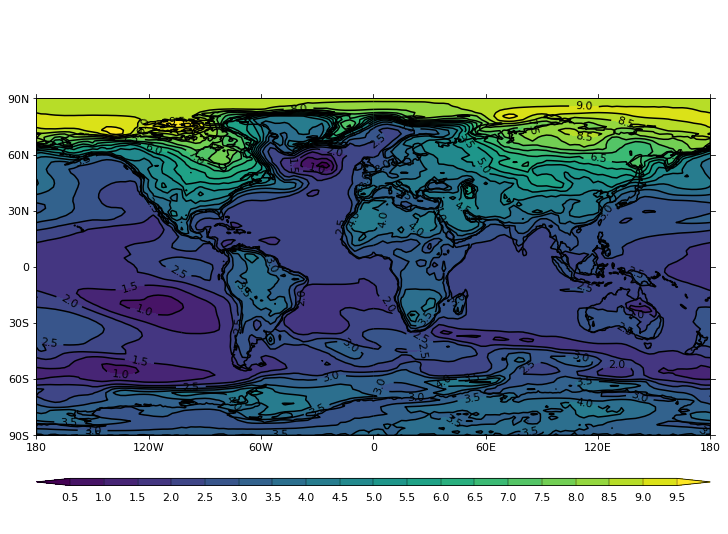

In [6]:
import cfplot as cfp

base_mean = all_data[('tas','baseline')][0]
rcp85_mean= all_data[('tas','rcp85')][0]
plot_data = np.transpose(rcp85_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1)




/home/haohcen/anaconda3/envs/irvine_erl_20/lib/python3.7/site-packages/cfplot/cfplot.py:3172: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plotvars.rows, plotvars.columns, pos)


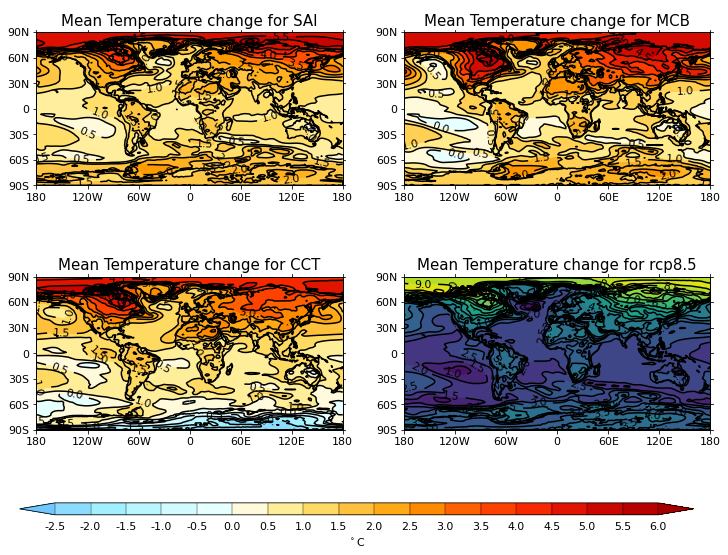

In [7]:
cfp.gopen(rows=2, columns=2, bottom=0.2)

cfp.gpos(1)
base_mean = all_data[('tas','baseline')][0]
sulf_mean= all_data[('tas','G6sulf')][0]
plot_data = np.transpose(sulf_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Mean Temperature change for SAI',colorbar=None)

cfp.gpos(2)
base_mean = all_data[('tas','baseline')][0]
ss_mean= all_data[('tas','G6ss')][0]
plot_data = np.transpose(ss_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Mean Temperature change for MCB',colorbar=None)

cfp.gpos(3)
base_mean = all_data[('tas','baseline')][0]
cct_mean= all_data[('tas','G6cct')][0]
plot_data = np.transpose(cct_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Mean Temperature change for CCT',colorbar_title='$^\circ$C',colorbar_position=[0.1, 0.1, 0.8, 0.02],
        colorbar_orientation='horizontal')

cfp.gpos(4)
base_mean = all_data[('tas','baseline')][0]
rcp85_mean= all_data[('tas','rcp85')][0]
plot_data = np.transpose(rcp85_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Mean Temperature change for rcp8.5', colorbar=None)
cfp.gclose()


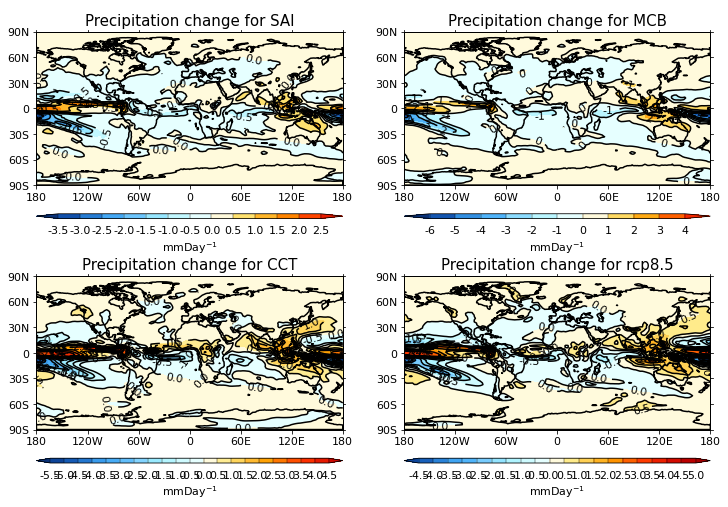

In [8]:
cfp.gopen(rows=2, columns=2, bottom=0.2)

cfp.gpos(1)
base_mean = all_data[('pr','baseline')][0]
sulf_mean= all_data[('pr','G6sulf')][0]
plot_data = np.transpose(sulf_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation change for SAI',colorbar_title='mmDay$^{-1}$')

cfp.gpos(2)
base_mean = all_data[('pr','baseline')][0]
ss_mean= all_data[('pr','G6ss')][0]
plot_data = np.transpose(ss_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation change for MCB',colorbar_title='mmDay$^{-1}$')

cfp.gpos(3)
base_mean = all_data[('pr','baseline')][0]
cct_mean= all_data[('pr','G6cct')][0]
plot_data = np.transpose(cct_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation change for CCT',colorbar_title='mmDay$^{-1}$')

cfp.gpos(4)
base_mean = all_data[('pr','baseline')][0]
rcp85_mean= all_data[('pr','rcp85')][0]
plot_data = np.transpose(rcp85_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation change for rcp8.5',colorbar_title='mmDay$^{-1}$')

cfp.gclose()


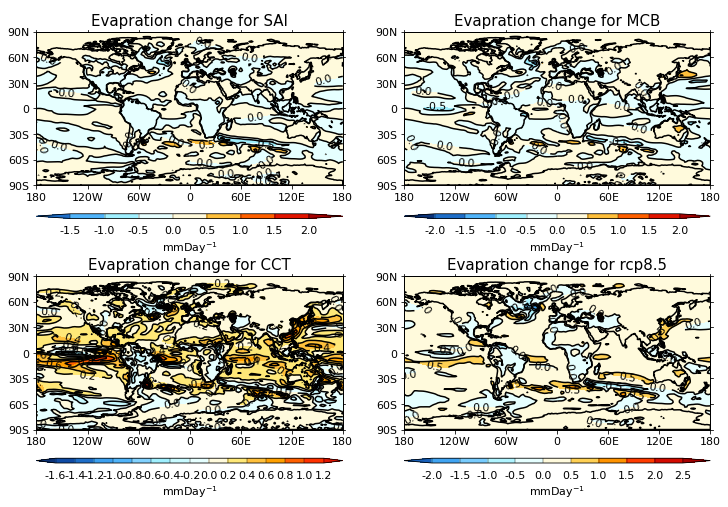

In [9]:
cfp.gopen(rows=2, columns=2, bottom=0.2)

cfp.gpos(1)
base_mean = all_data[('evspsbl','baseline')][0]
sulf_mean= all_data[('evspsbl','G6sulf')][0]
plot_data = np.transpose(sulf_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Evapration change for SAI',colorbar_title='mmDay$^{-1}$')

cfp.gpos(2)
base_mean = all_data[('evspsbl','baseline')][0]
ss_mean= all_data[('evspsbl','G6ss')][0]
plot_data = np.transpose(ss_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Evapration change for MCB',colorbar_title='mmDay$^{-1}$')

cfp.gpos(3)
base_mean = all_data[('evspsbl','baseline')][0]
cct_mean= all_data[('evspsbl','G6cct')][0]
plot_data = np.transpose(cct_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Evapration change for CCT',colorbar_title='mmDay$^{-1}$')

cfp.gpos(4)
base_mean = all_data[('evspsbl','baseline')][0]
rcp85_mean= all_data[('evspsbl','rcp85')][0]
plot_data = np.transpose(rcp85_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Evapration change for rcp8.5',colorbar_title='mmDay$^{-1}$')

cfp.gclose()

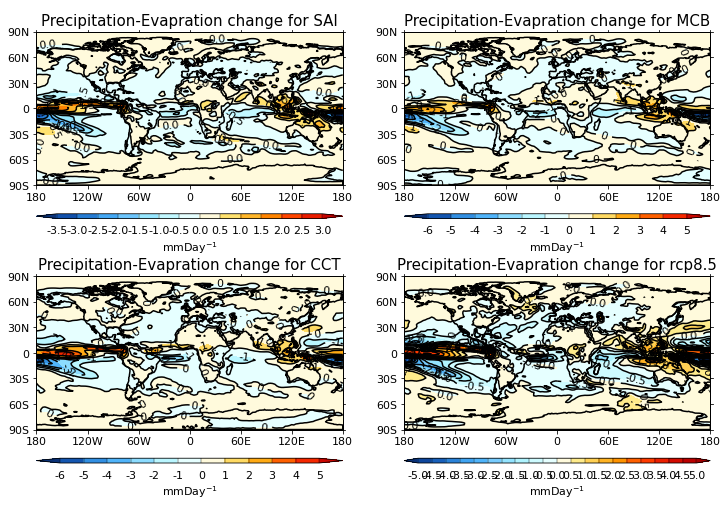

In [10]:
cfp.gopen(rows=2, columns=2, bottom=0.2)

cfp.gpos(1)
base_mean = all_data[('P-E','baseline')][0]
sulf_mean= all_data[('P-E','G6sulf')][0]
plot_data = np.transpose(sulf_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation-Evapration change for SAI',colorbar_title='mmDay$^{-1}$')

cfp.gpos(2)
base_mean = all_data[('P-E','baseline')][0]
ss_mean= all_data[('P-E','G6ss')][0]
plot_data = np.transpose(ss_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation-Evapration change for MCB',colorbar_title='mmDay$^{-1}$')

cfp.gpos(3)
base_mean = all_data[('P-E','baseline')][0]
cct_mean= all_data[('P-E','G6cct')][0]
plot_data = np.transpose(cct_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation-Evapration change for CCT',colorbar_title='mmDay$^{-1}$')

cfp.gpos(4)
base_mean = all_data[('P-E','baseline')][0]
rcp85_mean= all_data[('P-E','rcp85')][0]
plot_data = np.transpose(rcp85_mean - base_mean)

cfp.con(f=plot_data, x=lons_nor, y=lats_nor, ptype=1,title='Precipitation-Evapration change for rcp8.5',colorbar_title='mmDay$^{-1}$')

cfp.gclose()

In [11]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

# color guide here: https://www.w3schools.com/colors/colors_picker.asp
# color blender here: https://meyerweb.com/eric/tools/color-blend
red = '#ff0000'
l_red = '#ffc0c0' # old: '#ffd9d9'
blue = '#0066ff'
l_blue = '#c0c0ff' # old:'#b2d0ff'
purple = '#803380'
l_purple = '#C099C0' 
green='#99ff99'
l_green='#e6ffe6'
orange = '#e68a00'

std_alpha = 0.2

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

# INSERT FIGURE SECTIONS HERE

# Figure 1

In [13]:
import matplotlib.ticker as ticker

def box_rectangles(axis, quantiles, y_loc, color, thick):

    thin = thick*0.5
    thinner = thick*0.2

    # create a rectangle
    patches = [
        # 1-99% range
        mpatches.Rectangle((quantiles[0],y_loc-0.5*thinner), quantiles[-1] - quantiles[0], thinner, facecolor=color, linewidth=0), ### Background
        # 5-95% range
        mpatches.Rectangle((quantiles[1],y_loc-0.5*thin), quantiles[-2] - quantiles[1], thin, facecolor=color, linewidth=0), ### Background
        # 25-75% range
        mpatches.Rectangle((quantiles[2],y_loc-0.5*thick), quantiles[-3] - quantiles[2], thick, facecolor=color, linewidth=0), ### Background
    ]
    for p in patches:
        axis.add_patch(p)

    axis.plot([quantiles[3],quantiles[3]],[y_loc-0.5*thick,y_loc+0.5*thick],'w',linewidth=1)
#end def

def boxplot_n(axis, data_list, color_list):
    
    # number of boxplots to plot
    n = len(data_list)
    
    if len(color_list) != n:
        print('color list and data list are not the same length')
        return 'color list and data list are not the same length'
    
    # set plot thickness
    thick = (1.0 - 0.2) / (n * 1.5)
    
    # set y locations for bars
    y_step = 1.0 / n
    y_locations = [0.5 * y_step + y_step * IDX for IDX in range(n)]
    
    axis.set_ylim(0,1) # set y lims to 0 and 1
    axis.yaxis.set_major_locator(ticker.NullLocator()) # don't plot y ticks
    
    # Draw a zero line on the x-axis
    axis.plot([0,0],[0,1],'k',linewidth=1,zorder=0)
    
    # plot the shapes:
    for IDX in range(n):
        box_rectangles(axis, data_list[IDX], y_locations[IDX], color_list[IDX], thick)
#end def

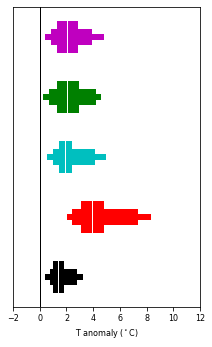

In [14]:
def plot_data(var, case_a, case_b, weight_name, quantiles = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]):
    # returns weighted quantiles of the anomaly for plotting
    # take anomaly of means [0] element
    anom = all_data[(var, case_a)][0] - all_data[(var, case_b)][0]
    anom_flat = anom.flatten()
    weight_flat = all_masks[weight_name].flatten()
    # return weighted quantiles of distribution
    return weighted_quantile(anom_flat, quantiles, sample_weight=weight_flat)

weight = 'land_noice_area'

var = 'tas'

case_list = ['rcp45','rcp85','G6sulf','G6ss','G6cct']

data_list = [plot_data(var, CASE, 'baseline', weight) for CASE in case_list]

color_list = ['k','r','c','g','m']

fig = plt.figure(figsize=cm2inch(8.5,14))
plt.rcParams.update({'font.size': 8})

"""
tas plot
"""
ax1 = fig.add_subplot(111)
ax=ax1

# plot data!
xlims=[-2,12]

boxplot_n(ax, data_list, color_list)

# set axes labels and title
unit = '$^\circ$C'
plt.xlabel('T anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.show()

# plt.text(1.3*xlims[0], 1.15, "a", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

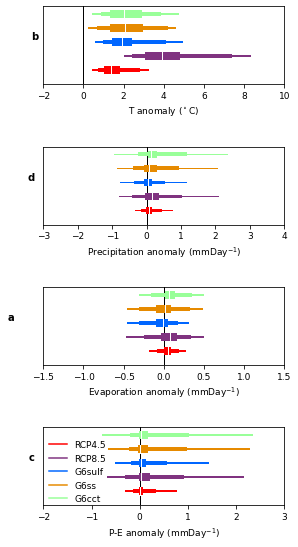

In [15]:
# %load figure_sections/fig_1.py

#customize ticks
import matplotlib.ticker as ticker

"""
Figure settings
"""

out_dir = '../figures/'

weight = 'land_noice_area'
out_filename = 'fig1'

# # For population-weighted version
# weight = 'pop'
# out_filename = 'fig1_pop'

quantiles = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]

"""
CASES:
'rcp45'
'rcp85'
'G6sulf'
'G6ss'
'G6cct'
"""

def plot_data(var, case_a, case_b, weight_name, quantiles = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]):
    # returns weighted quantiles of the anomaly for plotting
    # take anomaly of means [0] element
    anom = all_data[(var, case_a)][0] - all_data[(var, case_b)][0]
    anom_flat = anom.flatten()
    weight_flat = all_masks[weight_name].flatten()
    # return weighted quantiles of distribution
    return weighted_quantile(anom_flat, quantiles, sample_weight=weight_flat)

def box_rectangles(axis, quantiles, y_loc, thick, color):

    thin = thick*0.5
    thinner = thick*0.2

    # create a rectangle
    patches = [
        # 1-99% range
        mpatches.Rectangle((quantiles[0],y_loc-0.5*thinner), quantiles[-1] - quantiles[0], thinner, facecolor=color, linewidth=0), ### Background
        # 5-95% range
        mpatches.Rectangle((quantiles[1],y_loc-0.5*thin), quantiles[-2] - quantiles[1], thin, facecolor=color, linewidth=0), ### Background
        # 25-75% range
        mpatches.Rectangle((quantiles[2],y_loc-0.5*thick), quantiles[-3] - quantiles[2], thick, facecolor=color, linewidth=0), ### Background
    ]
    for p in patches:
        axis.add_patch(p)

    axis.plot([quantiles[3],quantiles[3]],[y_loc-0.5*thick,y_loc+0.5*thick],'w',linewidth=1)
#end def

def boxplot_3(axis,bottom,mid1,mid2,mid3,top,labels=False):
    """
    New NorESM style
    """
    
    # set y locations for bars
    y_bottom, y_mid1, y_mid2, y_mid3, y_top = 0.36,0.72,1.08,1.44,1.8

    # set basic thickness
    thick = 0.2
    
    axis.set_ylim(0,2)
    axis.yaxis.set_major_locator(ticker.NullLocator())
    
    axis.plot([0,0],[0,2],'k',linewidth=1,zorder=0)
    
    # plot the shapes:
    box_rectangles(axis, bottom, y_bottom, thick, red)
    box_rectangles(axis, mid1, y_mid1, thick, purple)
    box_rectangles(axis, mid2, y_mid2, thick, blue)
    box_rectangles(axis, mid3, y_mid3, thick, orange)
    box_rectangles(axis, top, y_top, thick, green)
#end def

"""
##################################
#
FIGURE 1 NorESM
#
##################################
"""


fig = plt.figure(figsize=cm2inch(10,16))

plt.rcParams.update({'font.size': 9})

def fig1_land(ax, var, mask):
    # get and then plot data
    rcp45_land = plot_data(var, 'rcp45', 'baseline', weight)
    rcp85_land = plot_data(var, 'rcp85', 'baseline', weight)
    G6sulf_land = plot_data(var, 'G6sulf', 'baseline', weight)
    G6ss_land = plot_data(var, 'G6ss', 'baseline', weight)
    G6cct_land = plot_data(var, 'G6cct', 'baseline', weight)
    
    boxplot_3(ax, rcp45_land, rcp85_land, G6sulf_land, G6ss_land, G6cct_land)

    
    
    
"""
tas plot
"""
ax1 = fig.add_subplot(411)
ax=ax1

# plot data!
var = 'tas'
xlims=[-2,10]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = '$^\circ$C'
plt.xlabel('T anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.3*xlims[0], 1.15, "b", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
pr plot
"""
ax2 = fig.add_subplot(412)
ax=ax2

# plot data!
var = 'pr'
xlims = [-3,4]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = 'mmDay$^{-1}$'
plt.xlabel('Precipitation anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.15*xlims[0], 1.15, "d", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')
 
    
"""
evspsbl plot
"""
ax3 = fig.add_subplot(413)
ax=ax3

# plot data!
var = 'evspsbl'
xlims=[-1.5,1.5]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = 'mmDay$^{-1}$'
plt.xlabel('Evaporation anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.3*xlims[0], 1.15, "a", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')


"""
P-E plot
"""
ax4 = fig.add_subplot(414)
ax=ax4

# plot data!
var = 'P-E'
xlims = [-2,3]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = 'mmDay$^{-1}$'
plt.xlabel('P-E anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.15*xlims[0], 1.15, "c", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')


"""
Plot legend
"""
# use empty plots
plt.plot(0,0, color=red, label='RCP4.5')
plt.plot(0,0, color=purple, label='RCP8.5')
plt.plot(0,0, color=blue, label='G6sulf')
plt.plot(0,0, color=orange, label='G6ss')
plt.plot(0,0, color=green, label='G6cct')

plt.legend(frameon=False, loc=3, bbox_to_anchor=(-0.01, -0.08))

"""
Figure finalizing
"""

#ax3.get_xaxis().set_ticks([-1.5,-1,-0.5,0,0.5,1.0,1.5])
#ax4.get_xaxis().set_ticks([-120,-80,-40,0,40,80,120])
# ax3.get_xaxis().set_ticks([-2.5,-2,-1.5,-1,-0.5,0,0.5,1.0,1.5,2.0,2.5])
# ax4.get_xaxis().set_ticks([-160,-120,-80,-40,0,40,80,120,160])

plt.subplots_adjust(top=1.2, bottom=0.1, left=0.10, right=0.95, hspace=0.8,
                    wspace=0.5)

plt.savefig(out_dir+out_filename+'.png', format='png', dpi=480)
plt.savefig(out_dir+out_filename+'.eps', format='eps', dpi=480)

plt.show()


# Figure 2

To produce the "half-GLENS" version of this plot, change the following variables in the "define cases" section to this:

out_name = 'fig_2_Half-GLENS'

y_label = 'Half-GLENS anomaly (mmd$^{-1}$)'

cases = ['Half-GLENS','RCP8.5','Baseline']

You can also change the variables in the same place.

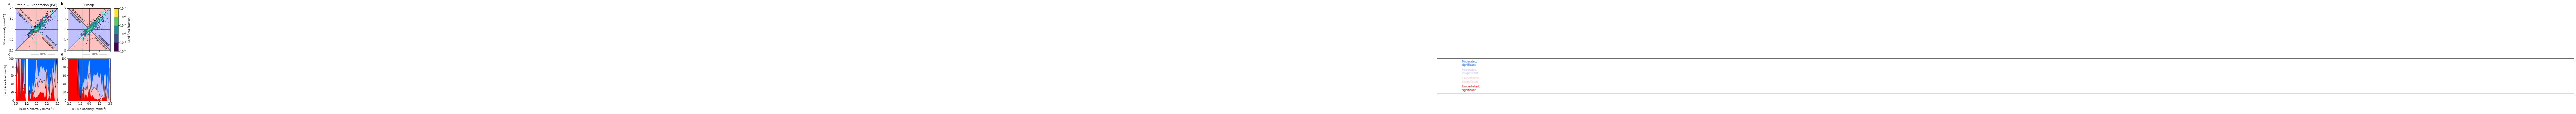

In [16]:
# %load figure_sections/fig_2.py

"""
2D histogram
"""
from get_NorESM_data import *

from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import gridspec
import matplotlib.patches as patches

"""
Define function to get data in format for plot
"""

def sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.1f'):
    
    axis.set_xlim(xlims)
    axis.set_ylim(ylims)

    axis.set_yticks(np.linspace(ylims[0],ylims[1],xnum_steps))
    axis.set_xticks(np.linspace(ylims[0],ylims[1],ynum_steps))

    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter(num_format))
    axis.yaxis.set_major_formatter(ticker.FormatStrFormatter(num_format))

def add_lines(axis):
    axis.axhline(0, color='k',zorder=0, lw=0.6)
    axis.axvline(0, color='k',zorder=0, lw=0.6)
    axis.plot(xlims,xlims, color='k',zorder=0, lw=0.6)
    axis.plot([xlims[0],-1.*xlims[0]],[-1.*xlims[0],xlims[0]], color='k',zorder=0, lw=0.6)
    
def bw_off_plot_func(CO2_anom,values,mask,weight):
    
    # Calculate fraction of CO2 anom distribution across values with weighted mask
    bwd = np.array(fraction_distribution(CO2_anom[mask], values, sample_weight=weight[mask]))
    # Return 100* fraction of points at each interval that are masked
    return 100 * bwd / (total * np.sum(weight) / np.sum(weight[mask]))

def plot_angled_labels(xlims):
    #plots angled labels to indicate moderated / exacerbated
    
    start_loc = (0.8/1.5)*xlims[1]
    top_left = [-1.*start_loc,start_loc]
    bottom_right = [start_loc,-1.*start_loc]
    shift = (0.2/1.5)*xlims[1]
    plt.text(top_left[0]-shift,top_left[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(top_left[0],top_left[1]+shift,'exacerbated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0]+shift,bottom_right[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0],bottom_right[1]-shift,'exacerbated',ha='center',va='center',rotation=-45)

def plot_range_top(ylims, q_range=[0.01,0.99]):
    # plots the 1-99% range of data vertically
    
    range_1_99 = weighted_quantile(CO2_anom.flatten(), q_range, sample_weight=weight)
    
    plt.plot([range_1_99[0],range_1_99[0]],[ylims[1],1.4*ylims[0]],color='0.5', lw=0.6, clip_on=False)
    plt.plot([range_1_99[1],range_1_99[1]],[ylims[1],1.4*ylims[0]],color='0.5', lw=0.6, clip_on=False)
    
    plt.plot([range_1_99[0],range_1_99[1]],[1.2*ylims[0],1.2*ylims[0]],color='0.5', lw=0.6, clip_on=False)
    plt.text( (range_1_99[0]+range_1_99[1])/2.0,1.2*ylims[0],'98%',va='center',ha='center',
             clip_on=False, color='black', bbox=dict(facecolor='white', edgecolor='white'))
    
def plot_range_bottom(q_range=[0.01,0.99]):
    range_1_99 = weighted_quantile(CO2_anom.flatten(), q_range, sample_weight=weight)
    plt.axvline(x=range_1_99[0],color='0.5', lw=0.6)
    plt.axvline(x=range_1_99[1],color='0.5', lw=0.6)
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    #https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
    
"""
Cases to plot
"""

out_dir = '../figures/'

out_name = 'fig_2_G6ss'
y_label = 'G6ss anomaly (mmd$^{-1}$)'
cases = ['G6ss','rcp85','baseline']

# out_name = 'fig_2_Half-GLENS'
# y_label = 'Half-GLENS anomaly (mmd$^{-1}$)'
# cases = ['Half-GLENS','RCP8.5','Baseline']

var_1 = 'P-E'
var_2 = 'pr'

flipped = False

# for flipped reverse order of baseline and RCP8.5 and invert plots
if flipped:
    cases_new = [cases[0],cases[2],cases[1]]
    cases = cases_new

"""
settings
"""

var_1_xlims = [-2.5,2.5]
var_1_xnum_steps = 5
var_1_bottom_step = 0.1

var_1_ticks = [-2.5,-1.2,0,1.2,2.5]
var_1_ticklabels = ['-2.5','-1.2','0.0','1.2','2.5']

var_1_aspect = 5./100. # set so bottom panel has same aspect ratio as top

var_2_xlims = [-2.5,2.5]
var_2_xnum_steps = 5
var_2_bottom_step = 0.1

var_2_ticks = [-2.5,-1.2,0,1.2,2.5]
var_2_ticklabels = ['-2.5','-1.2','0.0','1.2','2.5']

var_2_aspect = 5./100. # set so bottom panel has same aspect ratio as top

frac_100 = False
background = True
line_1_99_top = True
line_1_99_bottom = True
angled_labels = True

"""
Get mask
"""

weight = all_masks['land_noice_area'].flatten()

"""
Common settings
"""

bounds = [1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
labels = ['$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$']

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# g_cmap = plt.cm.gist_gray
# g_norm = mpl.colors.BoundaryNorm(bounds, g_cmap.N)

nbins = 200

"""
Create figure
"""

fig = plt.figure(figsize=cm2inch(15,13))
plt.rcParams.update({'font.size': 8})

"""
Start TOP
"""

"""
p-e no filter
"""

axis = fig.add_subplot(221)
ax_pe_top = axis

var = var_1

plt.title('Precip. - Evaporation (P-E)')

plt.axis('scaled')

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')
if flipped:
    CO2_anom = -1. * CO2_anom
    sg_anom  = -1. * sg_anom

# Set axes and add lines

xlims = var_1_xlims
ylims = xlims
xnum_steps = var_1_xnum_steps
ynum_steps = xnum_steps

sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.1f')

add_lines(axis)

# produce plot

img = axis.hist2d(CO2_anom.flatten(), sg_anom.flatten(), bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])
# img = ax_pe.hist2d(CO2_anom[certain], SRM_anom[certain], bins=100, range = [xlims,ylims], weights=weight[certain], norm=norm, cmap=cmap, cmin=1.e-12)

if line_1_99_top:
    plot_range_top(ylims)

if angled_labels:
    plot_angled_labels(xlims)
    
plt.ylabel(y_label)

if background:
    axis.set_facecolor(l_red)
    axis.fill_between(xlims, ylims, [-1.*ylims[0],-1.*ylims[1]], color=l_blue, zorder=0, lw=0)

plt.text(1.35*xlims[0], 1.15*xlims[1], "a", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')
    
"""
precip 5 max
"""

axis = fig.add_subplot(222)
ax_p5_top = axis

var = var_2

plt.title('Precip')

plt.axis('scaled')

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')
if flipped:
    CO2_anom = -1. * CO2_anom
    sg_anom  = -1. * sg_anom

# Set axes and add lines

xlims = var_2_xlims
ylims = xlims
xnum_steps = var_2_xnum_steps
ynum_steps = xnum_steps

sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.0f')

add_lines(axis)

# produce plot

img = axis.hist2d(CO2_anom.flatten(), sg_anom.flatten(), bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])

if line_1_99_top:
    plot_range_top(ylims)

if angled_labels:
    plot_angled_labels(xlims)
    
if background:
    axis.set_facecolor(l_red)
    axis.fill_between(xlims, ylims, [-1.*ylims[0],-1.*ylims[1]], color=l_blue, zorder=0, lw=0)
    
plt.text(1.35*xlims[0], 1.15*xlims[1], "b", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')
    
"""
Create BOTTOM figure
"""

"""
p-e no filter
"""

axis = fig.add_subplot(223)
ax_pe_mid = axis

# plt.title('Precip -Evap (mmd$^{-1}$)')

var = var_1

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')

xmin, xmax = var_1_xlims
step = var_1_bottom_step

values = np.arange(xmin, xmax+step, step) # need to extend just beyond end to add endpoint
centres = np.arange(xmin-step/2, xmax+step, step)

plt.ylim(0,100)
plt.xlim(xmin,xmax)

total = np.array(fraction_distribution(CO2_anom.flatten(), values, cumulative=False, sample_weight=weight))

better_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['better'],weight)
b_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['b_nosign'],weight) # better including non significant results
w_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['w_nosign'],weight) # worse "" ""
worse_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['worse'],weight)

# plot better
plt.fill_between(centres,100,100-b_nosign_plot,color=l_blue,lw=0)
plt.fill_between(centres,100,100-better_plot,color=blue,lw=0)
# plot worse
plt.fill_between(centres,0,w_nosign_plot,color=l_red,lw=0) # lw = 0 removes line at edges
plt.plot(centres,w_nosign_plot,color='k',lw=0.6)
plt.fill_between(centres,0,worse_plot,color=red,lw=0) # lw = 0 removes line at edges

if line_1_99_bottom:
    plot_range_bottom()

plt.ylabel('Land Area Fraction (%)')
plt.xlabel('RCP8.5 anomaly (mmd$^{-1}$)')

plt.text(1.35*var_1_xlims[0], 1.075*100, "c", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
precip 5 max
"""

axis = fig.add_subplot(224)
ax_p5_mid = axis

var = var_2

# plt.title('5 Day Max Precip (mmd$^{-1}$)')

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')

xmin, xmax = var_2_xlims
step = var_2_bottom_step

values = np.arange(xmin, xmax+step, step) # need to extend just beyond end to add endpoint
centres = np.arange(xmin-step/2, xmax+step, step)

plt.ylim(0,100)
plt.xlim(xmin,xmax)

total = np.array(fraction_distribution(CO2_anom.flatten(), values, cumulative=False, sample_weight=weight))

better_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['better'],weight)
b_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['b_nosign'],weight) # better including non significant results
w_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['w_nosign'],weight) # worse "" ""
worse_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['worse'],weight)

# plot better
plt.fill_between(centres,100,100-b_nosign_plot,color=l_blue,lw=0)
plt.fill_between(centres,100,100-better_plot,color=blue,lw=0)
# plot worse
plt.fill_between(centres,0,w_nosign_plot,color=l_red,lw=0) # lw = 0 removes line at edges
plt.plot(centres,w_nosign_plot,color='k',lw=0.6)
plt.fill_between(centres,0,worse_plot,color=red,lw=0) # lw = 0 removes line at edges

if line_1_99_bottom:
    plot_range_bottom()

plt.xlabel('RCP8.5 anomaly (mmd$^{-1}$)')

plt.text(1.35*var_2_xlims[0], 1.075*100, "d", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
add legend
"""

left_begin = 160
left_in = 3
bot_begin = 18

# Create a Rectangle patch
rect = patches.Rectangle((left_begin,bot_begin),135,82,linewidth=1,edgecolor='k',facecolor='white',clip_on=False)

# Add the patch to the Axes
ax_p5_mid.add_patch(rect)

plt.text(left_begin+left_in, 83, "Moderated,\nsignificant",clip_on=False, color=blue, 
         va="baseline", ha="left", multialignment="left")
plt.text(left_begin+left_in, 63, "Moderated,\ninsignificant",clip_on=False, color=l_blue,
         va="baseline", ha="left", multialignment="left")
plt.text(left_begin+left_in, 43, "Exacerbated,\ninsignificant",clip_on=False, color=l_red,
         va="baseline", ha="left", multialignment="left")
plt.text(left_begin+left_in, 23, "Exacerbated,\nsignificant",clip_on=False, color=red,
         va="baseline", ha="left", multialignment="left")

"""
Finish up figures
"""

fig.subplots_adjust(right=0.85)
# add_axes defines new area with: X_start, Y_start, width, height
cax = fig.add_axes([0.85,0.53,0.03,0.35])
cbar = fig.colorbar(img[3], cax=cax, ticks=bounds, format='%0.0e')
cbar.set_ticklabels(labels)
cbar.set_label('Land Area Fraction')

# reduce space between ticks and tick labels
ax_pe_top.tick_params(pad=2)
ax_p5_top.tick_params(pad=2)
ax_pe_mid.tick_params(pad=2)
ax_p5_mid.tick_params(pad=2)
cax.tick_params(pad=2)

# set PE ticks
ax_pe_top.get_xaxis().set_ticks(var_1_ticks)
ax_pe_mid.get_xaxis().set_ticks(var_1_ticks)
ax_pe_top.get_xaxis().set_ticklabels(var_1_ticklabels)
ax_pe_mid.get_xaxis().set_ticklabels(var_1_ticklabels)

ax_p5_top.get_xaxis().set_ticks(var_2_ticks)
ax_p5_top.get_yaxis().set_ticks(var_2_ticks)
ax_p5_mid.get_xaxis().set_ticks(var_2_ticks)

# hide top x axis tick labels
ax_pe_top.get_xaxis().set_ticklabels([])
ax_p5_top.get_xaxis().set_ticklabels([])

ax_pe_mid.set_aspect(var_1_aspect) # set so bottom panel has same aspect ratio as top
ax_p5_mid.set_aspect(var_2_aspect)

"""
colorbar articles:
https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.colorbar
https://matplotlib.org/users/colormapnorms.html
https://matplotlib.org/tutorials/colors/colorbar_only.html
https://stackoverflow.com/questions/21952100/setting-the-limits-on-a-colorbar-in-matplotlib
"""

fig.subplots_adjust(left=0.15, right=0.83, wspace = 0.2, hspace=0.2)

plt.savefig(out_dir+out_name+'.png', format='png', dpi=600)
plt.savefig(out_dir+out_name+'.eps', format='eps', dpi=600)
    
plt.show()


# Table 1

"Weight problem" warning can be ignored. It is a check to see if the weight adds to 1 but has been triggered by the final decimal point so isn't a problem.

In [17]:
from get_NorESM_data import *
# %load figure_sections/table_1.py
"""
Get better / worse off statistics for:
- land no ice area
- Full, half and perfect SG
- 90% T-Test, 80 years
"""

# output to here
table_dir = '../tables/'

weight = all_masks['land_noice_area']

case_combos = {'G6sulf': ['G6sulf','rcp85','baseline'],
               'G6ss': ['G6ss','rcp85','baseline'],
               'G6cct': ['G6cct','rcp85','baseline'],
              }

def bwdk_format(fractions):
    better = 'better: ' + "{:4.2f}".format(fractions['better']*100.)
    worse = ' worse: ' + "{:4.2f}".format(fractions['worse']*100.)
    dont_know = ' dont_know: ' + "{:4.2f}".format(fractions['dont_know']*100.)
    return better + worse + dont_know

# create a dictionary to store output of variable loop
var_dict = {}
for var in vars_noresm:
    
    # create a dict to store output of combo loop (wipes each var loop)
    combo_dict = {}
    for key, value in case_combos.items():
        sg_anom, co2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, value[0], value[1], value[2], var, weight)
        combo_dict[key] = bwdk_format(fractions)
    
    # store combo dict in var dict
    var_dict[var] = combo_dict
#end fors

land_noice_out = pd.DataFrame.from_dict(var_dict).to_csv(table_dir+'NorESM_land_noice_bwoff.csv')


# Figure 4 (there is no 3).

There are 2 code-sections here, first we generate the data for the plot (time-consuming) then we plot.

In [18]:
# %load figure_sections/fig_4_data.py

from get_NorESM_data import *
# import cf
from netCDF4 import Dataset
import numpy as np
from analysis import *
from config import *
"""
Code to generate input data for fraction summary figure
"""

def frac_figure_data(frac, var_list, all_data, all_masks, weight_name = 'land_noice_area', nyears=80, ttest_level=0.1):
    """
    function to generate a table of data to input to summary figure (fig "4" from NCC paper)
    """
    # Generate masks
    global_weight = all_masks['area'].flatten()
    weight = all_masks[weight_name].flatten()

    # create Dict to fill with data and then return
    inner_dict = {}
    
    #loop over all vars
    for var in var_list:

        """
        Generate Fraction-data
        """

        CO2_mean = all_data[var,'rcp85'][0].flatten()
        SRM_mean = all_data[var,'G6ss'][0].flatten()
        CTRL_mean = all_data[var,'baseline'][0].flatten()

        CO2_std = all_data[var,'rcp85'][1].flatten()
        SRM_std = all_data[var,'G6ss'][1].flatten()
        CTRL_std = all_data[var,'baseline'][1].flatten()

        """
        Generate Fraction-data
        """

        frac_mean = CO2_mean + frac*(SRM_mean - CO2_mean)
        frac_std = CO2_std + frac*(SRM_std - CO2_std)
        frac_anom = frac_mean - CTRL_mean

        """
        Generate fraction moderated / exacerbated
        """

        better, worse, dont_know = better_worse_off(frac_mean, frac_std, CO2_mean, CO2_std, CTRL_mean, CTRL_std, nyears, ttest_level)

        """
        Abs Frac Anom
        """
        
        abs_anom = abs(frac_anom)
        abs_std_anom = abs(frac_anom / CTRL_std)
        
        """
        Root-mean square
        """

        frac_anom_squared = frac_anom**2
        frac_std_anom_squared = (frac_anom / CTRL_std)**2
        RMS = ( np.sum(weight * frac_anom_squared) )**0.5
        RMS_std = ( np.sum(weight * frac_std_anom_squared) )**0.5

        """
        Fill dict with data
        """

        inner_dict[var+'_global'] = np.sum(frac_anom * global_weight)
        inner_dict[var+'_abs'] = np.sum(abs_anom * weight)
        inner_dict[var+'_abs_std'] = np.sum(abs_std_anom * weight)
        inner_dict[var+'_RMS'] = RMS
        inner_dict[var+'_RMS_std'] = RMS_std
        inner_dict[var+'_mod'] = np.sum(better.flatten() * weight)
        inner_dict[var+'_exa'] = np.sum(worse.flatten() * weight)
    #endfor var 
       
    # Return dict of output    
    return inner_dict
# end def frac_figure_data()

def dict_flipper(dict_to_flip):
    """
    Flips a 2-layer dictionary inside out
    """

    flip_dict = {}

    outer_keys = list(dict_to_flip.keys())
    inner_keys = list(dict_to_flip[outer_keys[0]].keys())

    for inner_key in inner_keys:
        
        temp_dict = {}

        for outer_key, inner_dict in dict_to_flip.items():
            temp_dict[outer_key] = inner_dict[inner_key]

        flip_dict[inner_key] = temp_dict
    
    # return flipped dict
    return flip_dict
#end def

"""
generate table of data for figure
"""

out_dir = "../tables/"

# Create an array of output from 0 to 1.5x GLENS
frac_array = np.arange(0.,1.51,0.01)

# fill a dictionary with the output
dict_variable = {round(FRAC,2):frac_figure_data(FRAC, vars_noresm, all_data, all_masks) for FRAC in frac_array}

# Flip the dictionary around to have frac as the inner element
flip_dict = dict_flipper(dict_variable)

"""
Output Dict to CSV
"""

pd.DataFrame.from_dict(flip_dict).to_csv(out_dir + 'results_by_frac_NorESM.csv')

# END


global precip restored at: 94 %
evspsbl  RMS at 0.5: 0.9425238103782655  RMS at 1.0:  0.9728345335232035
evspsbl  RMS minimum: 0.9414010440557631  minimized at: 58 %
pr  RMS at 0.5: 0.9390527942678741  RMS at 1.0:  0.9220345732824058
pr  RMS minimum: 0.921614950711878  minimized at: 93 %
P-E  RMS at 0.5: 0.9799534661844019  RMS at 1.0:  1.0014618171146379
P-E  RMS minimum: 0.9799469480933097  minimized at: 49 %
tas  RMS at 0.5: 0.7739076302171529  RMS at 1.0:  0.5555574496019069
tas  RMS minimum: 0.35935104863127976  minimized at: 150 %


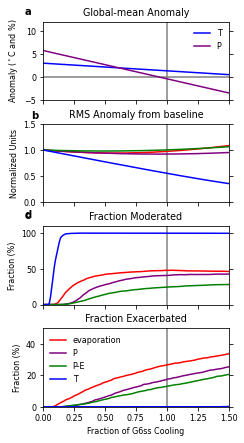

In [19]:
# %load figure_sections/fig_4.py
"""
Figure to plot RMS, etc. as a function of solar constant reduction
"""

out_dir = '../figures/'

# load up GeoMIP regional data
table_dir = '../tables/'
frac_pd = pd.read_csv(table_dir + 'results_by_frac_NorESM.csv')
frac_dict = frac_pd.to_dict()
# frac_pd = pd.DataFrame.from_csv(table_dir + 'results_by_frac_GLENS.csv')
# frac_dict = frac_pd.to_dict()

vars_all = ['evspsbl','pr','P-E','tas']
vars_no_p = ['evspsbl','pr','P-E','tas']

metrics = ['global','RMS','RMS_std','mod','exa']

# x-axis
x = frac_dict['P-E_RMS'].keys()
x_axis = np.array(list(x))*0.01

"""
Begin Plots
"""

fig = plt.figure(figsize=cm2inch(8.5,18))
plt.rcParams.update({'font.size': 8})

var_cols = {'evspsbl':'red',
            'pr':'purple',
            'tas':'blue',
            'P-E':'green',
            }

var_labels = {'tas':'T',
              'evspsbl':'evaporation',
              'P-E':'P-E',
              'pr':'P'}
            

"""
Global-mean plot
"""

ax1 = fig.add_subplot(411)

# generate control global-mean precip
control_precip = all_data['pr','baseline'][0].flatten()
global_weight = all_masks['land_noice_area'].flatten()
control_global_precip = np.sum(control_precip * global_weight)

global_temp = frac_pd['tas_global'].to_numpy()
global_precip_pc = 100.0 * (frac_pd['pr_global'].to_numpy() / control_global_precip)

print('global precip restored at:', np.abs(global_precip_pc).argmin(), "%")

plt.plot(x_axis, global_temp, color = var_cols['tas'], label= var_labels['tas'])
plt.plot(x_axis, global_precip_pc, color = 'purple', label = 'P')


plt.xlim(0,1.5)
plt.ylim(-5,12)

plt.axhline(0.,color='gray',zorder=0)
plt.axvline(1.,color='gray',zorder=0)

plt.title('Global-mean Anomaly')
plt.ylabel('Anomaly ($^\circ$C and %)')

plt.legend(frameon=False)

plt.text(-0.15, 1.12*12, "a", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
RMS plot
"""

ax2 = fig.add_subplot(412)

for var in vars_no_p:
    
    RMS = frac_pd[var+'_RMS'] / frac_pd[var+'_RMS'][0]
    RMS = RMS.to_numpy()
    plt.plot(x_axis, RMS, color = var_cols[var], label= var_labels[var])
    print(var,' RMS at 0.5:', RMS[50], ' RMS at 1.0: ', RMS[100])
#     print(var,' RMS at 0.5:', RMS[0.5], ' RMS at 1.0: ', RMS[1.0])
    print(var,' RMS minimum:', RMS.min(), ' minimized at:', RMS.argmin(), "%")

plt.ylim(0,1.5)
plt.xlim(0,1.5)

plt.axvline(1.,color='gray',zorder=0)

plt.title('RMS Anomaly from baseline')
plt.ylabel('Normalized Units')



plt.text(-0.1, 1.6, "b", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
Fraction moderated plot
"""

ax3 = fig.add_subplot(413)

for var in vars_no_p:
    
    mod = 100. * frac_pd[var+'_mod'].to_numpy()
    plt.plot(x_axis, mod, color = var_cols[var], label= var_labels[var])

plt.axvline(1.,color='gray',zorder=0)
    
plt.ylim(0,110)
plt.xlim(0,1.5)

plt.title('Fraction Moderated')
plt.ylabel('Fraction (%)')

plt.text(-0.15, 120, "c", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

# plt.legend(frameon=False)

"""
Fraction exacerbated plot
"""

ax4 = fig.add_subplot(414)

for var in vars_no_p:
    
    exa = 100. * frac_pd[var+'_exa'].to_numpy()
    plt.plot(x_axis, exa, color = var_cols[var], label= var_labels[var])

# plt.text(0.88,7,'half-SG',rotation=90)
plt.axvline(1.,color='gray',zorder=0)
    
plt.ylim(0,50)
plt.xlim(0,1.5)

plt.title('Fraction Exacerbated')
plt.ylabel('Fraction (%)')
plt.xlabel('Fraction of G6ss Cooling')

plt.legend(frameon=False)

plt.text(-0.15, 120, "d", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

# plt.legend(frameon=False)

"""
Tidy up figure
"""

ax1.get_xaxis().set_ticklabels([])
ax2.get_xaxis().set_ticklabels([])
ax3.get_xaxis().set_ticklabels([])

ax1.tick_params(axis='y', right=True)
ax2.tick_params(axis='y', right=True)
ax3.tick_params(axis='y', right=True)
ax4.tick_params(axis='y', right=True)

#ax2.get_yaxis().set_ticks([0.0,0.2,0.4,0.6,0.8,1.0])
#ax4.get_yaxis().set_ticks([0, 2, 4, 6, 8, 10])

fig.subplots_adjust(left=0.18, right=0.95, hspace=0.3)

plt.savefig(out_dir+'fig_4.png', format='png', dpi=480)
plt.savefig(out_dir+'fig_4.eps', format='eps', dpi=480)

plt.show()

 
#

In [20]:
# %load figure_sections/srex_region_maps.py
from get_NorESM_data import *
# import cf
from netCDF4 import Dataset
import numpy as np
from analysis import *
from config import *

"""
Set mask directories and names
"""

SREX_abvs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA', 'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS', 'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']
SREX_names = ['Alaska', 'Canada and Greenland', 'Western North America', 'Central North America', 'Eastern North America', 'Central America', 'Amazon', 'North Eastern Brazil', 'Western South America', 'Southern South America', 'Northern Europe', 'Central Europe', 'Mediterannean', 'Sahara', 'Western Africa', 'Eastern Africa', 'Southern Africa', 'Northern Asia', 'Western Asia', 'Central Asia', 'Tibet', 'Eastern Asia', 'Southern Asia', 'South Eastern Asia', 'Northern Australia', 'Southern Australia']


# This function gets the region masks from the file, masks them and reshapes them 
# to match the data_shape given.

def get_regions_for_mean(region_fileloc, region_name_list, data_shape, mask=None):
    """
    This function gets the region masks from the file, masks them and reshapes them 
    to match the data_shape given.
    """
    
    # This Sub-function normalizes the input mask
    def region_mask_norm(region_data, mask=None):
        # change from % to fraction
        region_1 = np.copy(region_data) / 100.
        # apply mask if present
        if mask is None:
            pass
        else:
            region_1 = region_1 * np.transpose(mask)
        # normalize region
        return region_1 / np.sum(region_1)
    # End DEF
    
    # load region data
    region_nc = Dataset(region_fileloc)
    # make list of mask data for regions
    region_nc_data_list = [ region_nc.variables[ X ][:] for X in region_name_list]
    # Normalize region mask data
    region_data_n_list = [ region_mask_norm( X, mask=mask ) for X in region_nc_data_list]
    # Expand mask along time dimension to have same shape as data_nc_data
    region_data_exp_list = [ np.repeat(X, data_shape[0], axis=0) for X in region_data_n_list]
    
    return region_data_exp_list
#END DEF: get_regions_for_mean(region_fileloc, region_name_list, data_shape, mask=None)

def regional_means_stds(var, case):
    """
    This function calculates regional-mean timeseries over the SREX regions
    """
    
    data = ensemble_process(var,case) # [0] to select means

    # transpose data to match form of region mask data
    data = np.transpose(data)

    region_dir = '../NorESM_fix/'
    region_file = 'NorESM1-M_SREX_sep.nc'
    
    region_fileloc = region_dir + region_file
    region_data_list = get_regions_for_mean(region_fileloc, SREX_abvs, np.shape(data), mask=all_masks['land_mask'])

    # weighted (S)patial mean of regions (over time):
    region_mean_s_list = [ np.sum(data * X, axis=(1,2)) for X in region_data_list ]

    #calculate mean and standard deviation over time.
    region_time_mean_list = [ np.mean(X) for X in region_mean_s_list ]
    region_time_std_list = [ np.std(X) for X in region_mean_s_list ]

    # Store mean and standard deviation in dict, with regions as "rows"
    mean_dict = dict(zip(SREX_abvs,region_time_mean_list))
    std_dict = dict(zip(SREX_abvs,region_time_std_list))
    
    return mean_dict, std_dict
#end def: regional_means_stds(var, case)

def make_plot_data(var, regional_data_dict, anom_type='units', ttest_level=0.1, nyears=20):
    """
    ttest_level: 0.1 = 90%, nyears: 20 as ensemble mean for each year calculated, which reduces stddev
    """
    
    def num_stds_ttest(nobs, ttest_level, num=1000):
        import numpy as np
        from scipy.stats import ttest_ind_from_stats
        """
        reports number of stds to pass a t-test of a given level for a certain number of years
        ttest_level: 0.1 = 90%, 0.05 = 95%
        """

        xfactor = 1. / num

        results = np.array([ttest_ind_from_stats(X * xfactor, 1, nobs, 0, 1, nobs)[1] for X in range(num)])
        num_stds = np.array([X * xfactor for X in range(num)])

        # return number of STDs for T-Test
        return min( num_stds [ results < ttest_level ])
    
    SREX_abvs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA', 'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS', 'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']
    SREX_names = ['Alaska', 'Canada and Greenland', 'Western North America', 'Central North America', 'Eastern North America', 'Central America', 'Amazon', 'North Eastern Brazil', 'Western South America', 'Southern South America', 'Northern Europe', 'Central Europe', 'Mediterannean', 'Sahara', 'Western Africa', 'Eastern Africa', 'Southern Africa', 'Northern Asia', 'Western Asia', 'Central Asia', 'Tibet', 'Eastern Asia', 'Southern Asia', 'South Eastern Asia', 'Northern Australia', 'Southern Australia']
    SREX_region_centres = [[-136.511,   66.277],[-57.5,  67.5],[-117.5  ,   44.283],[-95.   ,  39.283],[-72.5,  37.5],[-90.25802898,  16.60289305],[-62.05181777,  -3.75447446],[-42., -10.],[-75.89741775, -30.77603057],[-54.40601015, -38.77303345],[12.27138643, 64.46654867],[20.74534161, 50.5952795 ],[15. , 37.5],[10. , 22.5],[2.5   , 1.8175],[38.495 ,  1.8175],[ 20.995 , -23.1825],[110.,  60.],[50. , 32.5],[67.5, 40. ],[87.5, 40. ],[122.5,  35. ],[78.58108108, 17.90540541],[125.,   5.],[132.5, -20. ],[145., -40.]]
    
    # dictionary to hold plot data for each region
    SREX_plot_dict = {}
    for SREX in SREX_abvs:
        
        plot_dict = {} # temporary plot data dict
        
        plot_dict['name'] = SREX_names[SREX_abvs.index(SREX)] # use index from SREX_Abvs list to find matching entries
        plot_dict['centre'] = SREX_region_centres[SREX_abvs.index(SREX)]
        plot_dict['displace'] = [0,0] # these will be edited later
        
        # calculate various anomaly types
        
        # calculate number of STDs from control for 90% T-Test:
        num_ctrl_stds = num_stds_ttest(nyears, ttest_level)
        
        if anom_type == 'units':
            plot_dict['anom_85'] = regional_data_dict[var]['rcp85'][0][SREX] - regional_data_dict[var]['baseline'][0][SREX]
            plot_dict['anom_NorESM'] = regional_data_dict[var]['G6sulf'][0][SREX] - regional_data_dict[var]['baseline'][0][SREX]
            plot_dict['ttest_ctrl'] = num_ctrl_stds * regional_data_dict[var]['baseline'][1][SREX]
        elif anom_type == 'pc':
            plot_dict['anom_85'] = 100. * ((regional_data_dict[var]['rcp85'][0][SREX] / regional_data_dict[var]['baseline'][0][SREX]) - 1.0)
            plot_dict['anom_NorESM'] = 100. * ((regional_data_dict[var]['G6sulf'][0][SREX] / regional_data_dict[var]['baseline'][0][SREX]) - 1.0)
            plot_dict['ttest_ctrl'] = 100. * ((num_ctrl_stds * regional_data_dict[var]['baseline'][1][SREX]) / regional_data_dict[var]['baseline'][0][SREX])
        elif anom_type == 'sd':
            plot_dict['anom_85'] = (regional_data_dict[var]['rcp85'][0][SREX] - regional_data_dict[var]['baseline'][0][SREX]) / regional_data_dict[var]['baseline'][1][SREX]
            plot_dict['anom_NorESM'] = (regional_data_dict[var]['G6sulf'][0][SREX] - regional_data_dict[var]['baseline'][0][SREX]) / regional_data_dict[var]['baseline'][1][SREX]
            plot_dict['ttest_ctrl'] = num_ctrl_stds
        else:
            print("anom_type not recognized: ", anom_type," please input: units, pc or sd")
            return
        
        # check whether RCP8.5 and GLENS are significantly different:
        ttest_plevel = ttest_sub(regional_data_dict[var]['rcp85'][0][SREX], regional_data_dict[var]['rcp85'][1][SREX], nyears, regional_data_dict[var]['Full-GLENS'][0][SREX], regional_data_dict[var]['Full-GLENS'][1][SREX], nyears)
        plot_dict['ttest_anoms'] = ttest_plevel < ttest_level
        
        # Evaluate type of anomaly relationship for region (e.g. better_off but flipped sign, etc.)
        plot_dict['full_type']= all_anom_relations(regional_data_dict[var]['G6sulf'][0][SREX], regional_data_dict[var]['G6sulf'][1][SREX],
                                                   regional_data_dict[var]['rcp85'][0][SREX], regional_data_dict[var]['rcp85'][1][SREX],
                                                   regional_data_dict[var]['baseline'][0][SREX], regional_data_dict[var]['baseline'][1][SREX],
                                                   nyears, ttest_level)
        plot_dict['half_type']= all_anom_relations(regional_data_dict[var]['G6sulf'][0][SREX], regional_data_dict[var]['G6sulf'][1][SREX],
                                                   regional_data_dict[var]['rcp85'][0][SREX], regional_data_dict[var]['rcp85'][1][SREX],
                                                   regional_data_dict[var]['baseline'][0][SREX], regional_data_dict[var]['baseline'][1][SREX],
                                                   nyears, ttest_level)
        
        # define function to specify number format - longwinded!
        def num_format(num, anom_type):
            from math import log10, floor
            def rounder(num, sig=3):
                return round(num, sig-int(floor(log10(abs(num))))-1)
            #enddef
            if abs(num)>=100:
                string = "{:+3.0f}".format(num)
            elif abs(num)>10:
                num_r = rounder(num, sig=3)
                string = "{:+3.1f}".format(num_r)
            elif abs(num)>1:
                num_r = rounder(num, sig=3)
                string = "{:+3.2f}".format(num_r)
            elif abs(num)>0.1:
                num_r = rounder(num, sig=2)
                string = "{:+3.2f}".format(num_r)
            else:
                num_r = rounder(num, sig=1)
                string = "{:+3.2f}".format(num_r)
            if anom_type == 'pc':
                string = string + "%"
            return string
                   
        plot_dict['anom_85_text'] = num_format(plot_dict['anom_85'],anom_type)
        plot_dict['anom_NorESM_text'] = num_format(plot_dict['anom_NorESM'],anom_type)
        
        SREX_plot_dict[SREX] = plot_dict
    # end for SREX_abvs
                   
    return SREX_plot_dict
#end def make_plot_data()

def num_region_types(plot_data):
    """
    This function returns a dictionary listing the number of regions with each type of anom relationship
    """

    # a mutually exclusive list of anomaly relationships 
    group_dict_exclusive_list=['dont_know_small','dont_know_big_none','dont_know_big_over',
                          'better_off_perfect','better_off_under','better_off_over',
                          'worse_off_novel','worse_off_exacerbate','worse_off_too_much']
    SREX_abvs = ['ALA', 'CGI', 'WNA', 'CNA', 'ENA', 'CAM', 'AMZ', 'NEB', 'WSA', 'SSA', 'NEU', 'CEU', 'MED', 'SAH', 'WAF', 'EAF', 'SAF', 'NAS', 'WAS', 'CAS', 'TIB', 'EAS', 'SAS', 'SEA', 'NAU', 'SAU']

    region_types_full = [plot_data[IDX]['full_type'] for IDX in SREX_abvs]
    region_types_half = [plot_data[IDX]['half_type'] for IDX in SREX_abvs]

    full_type_num_dict = {}
    half_type_num_dict = {}
    for anom_type in group_dict_exclusive_list:
        full_type_num_dict[anom_type] = len([IDX for IDX in region_types_full if IDX is anom_type])
        half_type_num_dict[anom_type] = len([IDX for IDX in region_types_half if IDX is anom_type])

    return full_type_num_dict, half_type_num_dict

"""
Create nested dictionary with regional means and stds.
To access data:
regional_data_dict[var][case][0/1][SREX_ABV]
[0] for mean, [1] for std
"""

"""
Create regional_data_dict
"""
case_list = ['baseline','rcp85','G6sulf','G6ss','G6cct']

var_dict = {} # create dict to store loops output
for var in vars_noresm:
    case_dict = {} # create dict to store loops output
    for case in case_list:
        case_dict[case] = regional_means_stds(var, case)
    var_dict[var] = case_dict

# Rename var_dict
regional_data_dict = var_dict

"""
Make data for each variable plot
"""

tas_regions = make_plot_data('tas', regional_data_dict, anom_type='units')
pr_regions = make_plot_data('pr', regional_data_dict, anom_type='units')
evspsbl_regions = make_plot_data('evspsbl', regional_data_dict, anom_type='units')
PE_regions = make_plot_data('P-E', regional_data_dict, anom_type='units')

"""
Specify Common plot_Region_dict updates
"""

displace_dict = {'CAM': [-5.0,-5.0],
                 'NEB': [5.0,2.0],
                 'ENA': [5.0,-5.0],
                 'WSA': [-8.,2.],
                 'WAF': [0.0,-5.0],
                 'SAF': [5.0,-10.0],
                 'SAH': [-8.0,0.0],
                 'MED': [8.0,-2.],
                 'CEU': [10.,20.0],
                 'NEU': [-8.,5.],
                 'CAS': [5.0,25.0],
                 'SAS': [0.0, -5.0],
                 'SAU': [10.,-5.],
                }

def plot_srex_region_map(var_regions,out_loc, title):
    """
    Function to plot srex region map
    """
    
    # Import
    import regionmask
    import cartopy.crs as ccrs
    
    # plot updates
    plt.rcParams.update({'font.size': 10})
    plt.rcParams.update({'figure.figsize': (18,9)}) # Square panels (2 across a page)
    
    def mini_panels(axis, plot_dict, half_width = 8):

        # extract values from plot_dict
        anom_1 = plot_dict['anom_85']
        anom_2 = plot_dict['anom_NorESM']
        ttest_anom = plot_dict['ttest_ctrl']
        x_loc, y_loc = plot_dict['centre']
        displace_x, displace_y = plot_dict['displace']
        text_1 = plot_dict['anom_85_text']
        text_2 = plot_dict['anom_NorESM_text']

        """
        Displace origin if needed and plot line
        """
        if plot_dict['displace'] != [0,0]:

            x_loc_orig, y_loc_orig = x_loc, y_loc

            x_loc = x_loc + displace_x
            y_loc = y_loc + displace_y

            axis.plot([x_loc,x_loc_orig],[y_loc,y_loc_orig],'k',linewidth=3, zorder=2)

        """
        Normalize anomalies for plotting
        """
        big_anom = max(abs(anom_1),abs(anom_2))
        norm_value = max(big_anom,abs(2.*ttest_anom))

        norm_anom_1 = anom_1 / norm_value
        norm_anom_2 = anom_2 / norm_value
        norm_ttest_anom = ttest_anom / norm_value

        # Set some plotting standards
        thick = 0.3
        bar_loc = 0.6
        text_shift = 0.05

        """
        Create the background and anomalies
        """
        patches = [
            # Black Border for Background
            mpatches.Rectangle((x_loc - 1.05*half_width,y_loc - 1.15*half_width), 2.1*half_width, 2.6*half_width, facecolor='k', linewidth=0, zorder=3),
            # White Background
            mpatches.Rectangle((x_loc - half_width,y_loc - 1.1*half_width), 2*half_width, 2.5*half_width, facecolor='white', linewidth=0, zorder=3),
            # Ttest grey bar
            mpatches.Rectangle((x_loc - half_width,y_loc - norm_ttest_anom * half_width), 2*half_width, 2.* norm_ttest_anom * half_width, facecolor='gray', linewidth=0, zorder=3),
            # Anom_1
            mpatches.Rectangle((x_loc - (bar_loc + 0.5*thick) * half_width,y_loc), thick*half_width, norm_anom_1 * half_width, facecolor='r', linewidth=0, zorder=4),
            # Anom_2
            mpatches.Rectangle((x_loc + (bar_loc - 0.5*thick) * half_width,y_loc), thick*half_width, norm_anom_2 * half_width, facecolor='b', linewidth=0, zorder=4),        
        ]
        for p in patches:
            axis.add_patch(p)

        """
        Add the lines
        """
        #zero line
        axis.plot([x_loc - half_width,x_loc + half_width],[y_loc,y_loc],'k',linewidth=1, zorder=5)

        #Between line
        axis.plot([x_loc - (bar_loc * half_width), x_loc + (bar_loc * half_width)],[y_loc + (norm_anom_1 * half_width),y_loc + (norm_anom_2 * half_width)],'k',linewidth=1, zorder=3)

        #Half-way Point
        axis.plot([x_loc],[y_loc + 0.5 * (norm_anom_1 + norm_anom_2) * half_width],color='purple', marker='.', markersize=12, zorder=4)

        """
        Add the text values
        """
        #text
        axis.text(x_loc - (bar_loc - text_shift) * half_width, y_loc + 1.05*half_width, text_1,  horizontalalignment='center', verticalalignment='bottom', fontsize=8, zorder=4)
        axis.text(x_loc + (bar_loc - text_shift) * half_width, y_loc + 1.05*half_width, text_2,  horizontalalignment='center', verticalalignment='bottom', fontsize=8, zorder=4)
        ### FIN ###
    #end def mini_panels()
    
    """
    Apply common updates to plot_dict
    """
    # Function to update plot_regions_dict
    def update_plot_regions(plot_regions_dict, plot_value, update_dict):
        for SREX, update_value in update_dict.items():
            plot_regions_dict[SREX][plot_value] = update_value
    #end def
    
    update_plot_regions(var_regions,'displace', displace_dict)

    """
    Create SREX mask used as base for summary plot
    """
    ax = regionmask.defined_regions.srex.plot(add_label=False, line_kws={'zorder':1, 'linewidth':1})
    plt.title(title, fontsize = 16)
    plt.tight_layout()

    """
    Plot mini-panels for each SREX region
    """
    for SREX in SREX_abvs:
        mini_panels(ax, var_regions[SREX])

    """
    Save Figure
    """    
    plt.savefig(out_loc+'.eps', format='eps', dpi=480)
    plt.savefig(out_loc+'.png', format='png', dpi=480)
    plt.show()
# end def

"""
Actually Make the Plots!
"""


out_dir = '../figures/'

# Plot T
plot_srex_region_map(tas_regions,out_dir + 'tas_SREX_region_map', 'Surface Air Temperature (T, $^\circ$C)')

# Plot P
plot_srex_region_map(pr_regions,out_dir + 'pr_SREX_region_map', 'Precipitation (P, mmDay$^{-1}$)')

# Plot Pmax
plot_srex_region_map(evspsbl_regions,out_dir + 'evspsbl_SREX_region_map', 'Max. Precipitation (Pmax, mmDay$^{-1}$)')

# Plot P-E
plot_srex_region_map(PE_regions,out_dir + 'P-E_SREX_region_map', 'Precipitation minus Evaporation (P-E, mmDay$^{-1}$)')


baseline  not listed


IndexError: tuple index out of range

In [ ]:

file_dir = '../NorESM_fix/'
filename = 'NorESM1-M_weights.nc'
fileloc = file_dir + filename
test_nc = Dataset(fileloc)
test_nc



In [ ]:
glens_dir = '../glens_data/'
glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)
test_nc


# I've not been able to get the Region Bar-plot Figure to work, so it has been excluded.
Code for this figure is in "figure_sections/srex_region_maps.py"

# !!! End of Paper Code !!!

# Below is some potentially useful code for opening nextcdf, checking content and mapping results


In [ ]:
"""
Example netcdf file of annual series + gather lons and lats
"""

"""
variables(dimensions): float64 time(time), float64 time_bnds(time,bnds), 
    float64 lat(lat), float64 lon(lon), float64 gw(lat), float64 ch4vmr(time), 
    float64 co2vmr(time), int32 ndcur(time), int32 date(time), int32 nscur(time), 
    float64 sol_tsi(time), int32 nsteph(time), float64 f11vmr(time), float64 n2ovmr(time), 
    int32 datesec(time), float64 f12vmr(time), float32 TREFHT(time,lat,lon)
"""

var='TREFHT'
exp='control'
run='001'
file_years='201001-209912'

glens_dir = '../glens_data/'
glens_filename = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'.format(exp=exp,run=run,var=var,years=file_years)

glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)

lons = np.array(test_nc.variables['lon'][:])
lats = np.array(test_nc.variables['lat'][:])

# grid-weights by latitude
gw = test_nc.variables['gw'][:]
gw_2D = np.tile(gw, (lons.size,1))
gw_2D = gw_2D / np.sum(gw_2D)

In [ ]:
# #Get example netcdf
# glens_dir = '../glens_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

fix_dir = '../glens_fix/'
filename = 'sftlf_CCSM4.nc'
test_nc = Dataset(fix_dir + filename)

nc_data = test_nc.variables['sftlf'][:].transpose()

In [ ]:
nc_data.shape

In [ ]:
    """
    MASKS:
    'land_mask' - binary land mask where land fraction > 50%
    'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    WEIGHTS:
    'pop' - gridcell weighting by population fraction
    'ag' - gridcell weighting by agricultural land fraction
    'area' - simple gridcell weighting by area
    'land_area' - land area weighting using raw land area fraction (not mask)
    'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
    """

In [ ]:
"""
Example cartopy plot

http://earthpy.org/tag/cartopy.html
https://scitools.org.uk/cartopy/docs/v0.16/matplotlib/advanced_plotting.html
"""

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs

from cartopy.util import add_cyclic_point

# #Get example netcdf
# glens_dir = '../glens_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

# nc_data = test_nc.variables['TREFHT'][:].transpose()
# data = np.mean(nc_data,2)

# data = all_masks['land_noice_mask'].transpose()
mask = all_masks['land_noice_area']#.transpose()

data = mask
# data = (all_data[('TREFHT','RCP8.5')][0] - all_data[('TREFHT','Baseline')][0])
# data = all_data[('P-E','Baseline')][0] * (all_data[('P-E','Baseline')][0] < 0) * (all_data[('P-E','Baseline')][0] > -0.5) * mask
# data = all_data[('P-E','Full-GLENS')][0] * (all_data[('P-E','Full-GLENS')][0] < 0) * (all_data[('P-E','Full-GLENS')][0] > -1.0) * mask
# data = all_data[('P-E','RCP8.5')][0] * (all_data[('P-E','RCP8.5')][0] < 0) * (all_data[('P-E','RCP8.5')][0] > -1.0) * mask
# data = np.transpose(all_masks['land_frac'])

fig = plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax = plt.axes(projection=ccrs.PlateCarree())

# plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

lons2d, lats2d = np.meshgrid(lons, lats)

CS = plt.contourf(lons2d, lats2d, data.transpose(), 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

fig.colorbar(CS) #cm.ScalarMappable(),ax=ax)

plt.show()

data

In [ ]:
plt.imshow(all_data[('P-E','RCP8.5')][0])